# gpusvf (production-version)
A GPU-accelerated algorithm for calculating sky view factor for a given DSM and tree layer

In [1]:
import os, os.path
import rasterio as rio
from osgeo import gdal
from osgeo.gdalconst import *
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import time
import math
import struct


dsmfile = demfile = r"E:\Code\gpusvf\gpusvf\test_data\BG_1F.tif"	# DSM 文件(Ground + Building)
treefile = r"E:\Code\gpusvf\gpusvf\test_data\Vege_1F.tif"			# Vege 文件(Tree)


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1)
with rasterio.open(treefile) as treelayer:
    treeimg = treelayer.read(1)

gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(float)
tree = treeimg.astype(float)
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]

# 处理 NoData 值
nodata_value = -3.4028234663852886e+38
dsm = np.where(dsm == nodata_value, np.nan, dsm)
tree = np.where(tree < 0, 0, tree)

# 用邻近值插值 NaN 值，或者简单地设置为平均高程
if np.isnan(dsm).any():
    valid_data = dsm[~np.isnan(dsm)]
    if len(valid_data) > 0:
        min_valid = np.min(valid_data)
        dsm = np.where(np.isnan(dsm), min_valid, dsm)

if np.isnan(tree).any():
    valid_data = tree[~np.isnan(tree)]
    if len(valid_data) > 0:
        min_valid = np.min(valid_data)
        tree = np.where(np.isnan(tree), min_valid, tree)

print(f"DSM shape: {dsm.shape}, Tree shape: {tree.shape}")
print(f"DSM value range: {np.min(dsm)} to {np.max(dsm)}, Tree value range: {np.min(tree)} to {np.max(tree)}")
print(f"GeoTransform: {geotransform}")
print(f"Scale: {scale}")


DSM shape: (2001, 2001), Tree shape: (2001, 2001)
DSM value range: -1.0700000524520874 to 24.65987205505371, Tree value range: 0.0 to 13.632522583007812
GeoTransform: (42012.5, 0.5, 0.0, 25352.5, 0.0, -0.5)
Scale: 2.0


d:\ProgramData\anaconda3\envs\gpusvf\lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# Cupy-version

In [2]:
# Block 1: 检测CuPy是否正确安装以及配置
import cupy as cp
import numpy as np

# 检查CUDA是否可用
print("CuPy version:", cp.__version__)
print("CUDA available:", cp.cuda.is_available())

if cp.cuda.is_available():
    # 显示GPU信息
    device = cp.cuda.Device()
    print("GPU device count:", cp.cuda.runtime.getDeviceCount())
    print("Current device:", device.id)
    print("Total memory:", device.mem_info[1] / (1024**3), "GB")
    print("Free memory:", device.mem_info[0] / (1024**3), "GB")
    
    # 简单测试
    a_cp = cp.array([1, 2, 3, 4, 5])
    b_cp = cp.array([6, 7, 8, 9, 10])
    c_cp = a_cp + b_cp
    print("CuPy test result:", c_cp)
    print("Test successful!")
else:
    print("CUDA is not available. Please check your CuPy installation.")

CuPy version: 13.6.0
CUDA available: True
GPU device count: 1
Current device: 0
Total memory: 11.99951171875 GB
Free memory: 10.8125 GB
CuPy test result: [ 7  9 11 13 15]
Test successful!


In [3]:
# Block 2: GPU编码文件
import cupy as cp

svf_shadowcasting_kernel_code = r'''
#define PI 3.1415926f

__device__ float annulus_weight(float altitude, float aziinterval) {
    float n = 90.0f;
    float steprad = (360.0f/aziinterval) * PI/180.0f;
    float annulus = 91.0f - altitude;
    float w = 1.0f/(2.0f*PI) * sinf(PI / (2.0f*n)) * sinf((PI * (2.0f * annulus - 1.0f)) / (2.0f * n));
    return steprad * w;
}

extern "C" __global__ void svf_shadowcasting_cupy(
    float* svf_Latt, float* dsm_Latt, float* tree_Latt, float scale, int imageW, int imageH, int rangeDist) // 新增 rangeDist 参数
{
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;

    if (x >= imageW || y >= imageH) return;

    int index4 = x + y * imageW;

    // 如果当前位置有树且树高>0，认为站在树下，SVF=0 (性能优化，予以保留)
    if (tree_Latt[index4] > 0.0f) {
        svf_Latt[index4] = 0.03f;
        return;
    }

    // 穹顶分区参数
    float iangle[8] = {6, 18, 30, 42, 54, 66, 78, 90};
    float aziinterval[8] = {30, 30, 24, 24, 18, 12, 6, 1};
    float annulino[9] = {0, 12, 24, 36, 48, 60, 72, 84, 90};

    float svf = 0.0f;
    int idx = 0;
    // 计算每个分区的SVF
    for (int i = 0; i < 8; i++) {
        for (int j = 0; j < (int)aziinterval[i]; j++) {
            float altitude = iangle[i];
            float azimuth = j * (360.0f/aziinterval[i]);
            float altitude_rad = PI * altitude / 180.0f;
            float theta;
            // 太阳方位角转换
            if (azimuth < 90.0f && azimuth > 0.0f) {
                theta = PI * (90.0f - azimuth) / 180.0f;
            } else {
                theta = PI * (450.0f - azimuth) / 180.0f;
            }

            // --- 核心算法修改 ---
            float f = dsm_Latt[index4]; // 视线高度初始化为当前点高程
            float h_orig = f; // 保存原始地面高度

            // 修改1: 使用动态的 rangeDist，并从 radius=1.0f 开始避免采样自身
            for (float radius = 1.0f; radius < rangeDist; radius += 1.0f) {
                float x_f = x + radius * cosf(theta);
                float y_f = y - radius * sinf(theta);

                // 检查浮点坐标是否越界，并为双线性插值留出1个像素的边界
                if (x_f < 0.0f || x_f >= imageW - 1.0f || y_f < 0.0f || y_f >= imageH - 1.0f) break;

                // 修改2: 使用双线性插值法，解决边缘突变问题
                int x1 = (int)floorf(x_f);
                int y1 = (int)floorf(y_f);

                float x_frac = x_f - x1;
                float y_frac = y_f - y1;

                // 读取周围4个像素的高度和树高
                float h11 = dsm_Latt[x1 + y1 * imageW];
                float t11 = tree_Latt[x1 + y1 * imageW];
                if (t11 > 0.0f) h11 += 6.0f;

                float h12 = dsm_Latt[x1 + (y1 + 1) * imageW];
                float t12 = tree_Latt[x1 + (y1 + 1) * imageW];
                if (t12 > 0.0f) h12 += 6.0f;

                float h21 = dsm_Latt[(x1 + 1) + y1 * imageW];
                float t21 = tree_Latt[(x1 + 1) + y1 * imageW];
                if (t21 > 0.0f) h21 += 6.0f;

                float h22 = dsm_Latt[(x1 + 1) + (y1 + 1) * imageW];
                float t22 = tree_Latt[(x1 + 1) + (y1 + 1) * imageW];
                if (t22 > 0.0f) h22 += 6.0f;

                // 对高度进行双线性插值
                float h_top = h11 * (1.0f - x_frac) + h21 * x_frac;
                float h_bottom = h12 * (1.0f - x_frac) + h22 * x_frac;
                float height1 = h_top * (1.0f - y_frac) + h_bottom * y_frac;

                // 寻找路径上的最大遮挡高度角
                float temp = height1 - radius * tanf(altitude_rad) / scale;
                if (f < temp) f = temp;

                // 修改3: 移除了有风险的 "首次命中即中断" 的 break 语句
            }

            float sh = 0.0f;
            if (f == h_orig) { // 如果最大视线高度没有超过起始点高度，则天空可见
                sh = 1.0f;
            }
            // --------------------

            for (int k = (int)annulino[i] + 1; k < (int)annulino[i + 1] + 1; k++) {
                float weight = annulus_weight((float)k, aziinterval[i]);
                weight *= sh;
                svf += weight;
            }
            idx++;
        }
    }
    svf_Latt[index4] = svf;
}
'''

# 编译内核
svf_shadowcasting_kernel = cp.RawKernel(svf_shadowcasting_kernel_code, 'svf_shadowcasting_cupy')

In [4]:
# Block 3: 剩下的其他部分
import time

def svfCalculator_ShadowCastingOnGPU(dsm, tree, scale, range_dist): 
    '''This code is used to calculate the sky view factor using the ray-tracing
    algorithm based on the GPU acceleration
    
    Parameters:
        dsm: the numpy array of the digital surface model
        tree: the numpy array of the tree canopy model
        scale: is the scale of the image, read from the gdal
        range_dist: the maximum search radius for ray tracing
    '''
    # 将输入数据转换为CuPy数组
    px = cp.asarray(dsm).astype(cp.float32)
    tree_px = cp.asarray(tree).astype(cp.float32)
    
    height, width = px.shape
    
    # 设置线程块和网格大小
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1

    # 创建输出数组
    newLattice_gpu = cp.empty_like(px)
    
    # 调用内核
    svf_shadowcasting_kernel(
        (nb_blocksY, nb_blocksX),
        (nb_ThreadsY, nb_ThreadsX),
        (newLattice_gpu, px, tree_px, cp.float32(scale), width, height, int(range_dist))
    )
    
    # 等待GPU计算完成
    cp.cuda.Stream.null.synchronize()
    bwPx = cp.asnumpy(newLattice_gpu)
    
    return bwPx

# Block 4: 保存为GeoTIFF的函数
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    
    # close the datasets
    outBand = None
    outDs = None
    gdal_data = None

Processing image with shape: (2001, 2001)
The time elapsed is: 5.77 seconds
Saved result to E:\Code\gpusvf\gpusvf\test_data\gpusvf_1F.tif


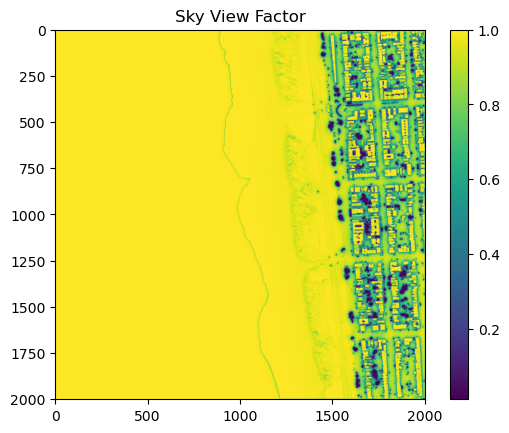

In [5]:
# Block 5: 主处理流程 (根据您的环境修改)
t1 = time.time()

# 使用您已经读取的dsm数据
dsm_img = dsm
tree_img = tree

print(f"Processing image with shape: {dsm_img.shape}")

# 新增: 动态计算一个安全的搜索半径，确保光线能追踪到图像对角线距离
height, width = dsm_img.shape
range_dist = int(np.sqrt(width**2 + height**2))

# 计算SVF，并传入新的搜索半径参数
res = svfCalculator_ShadowCastingOnGPU(dsm_img, tree_img, np.float32(scale), range_dist)

# 处理无穷大和NaN值
res = np.where(np.isinf(res), 1.0, res)  # 将无穷大值设为1
res = np.where(np.isnan(res), 1.0, res)  # 将NaN值设为1
res = np.clip(res, 0.0, 1.0)

t2 = time.time()
print(f'The time elapsed is: {t2-t1:.2f} seconds')

# 保存结果
output_filename = r"E:\Code\gpusvf\gpusvf\test_data\gpusvf_1F.tif"
saverasternd(gdal_dsm, output_filename, np.asarray(res))
print(f"Saved result to {output_filename}")

# 可视化结果
plt.imshow(np.asarray(res))
plt.colorbar()
plt.title("Sky View Factor")
plt.savefig(r"E:\Code\gpusvf\gpusvf\test_data\gpusvf_1F.png", dpi=300)
plt.show()

# 清理资源
gdal_dsm = None